In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

plt.style.use('seaborn-poster')

## **Exploración de los datos**

In [3]:
df = pd.read_csv('./../data/Solar_Energy_Production.csv')
df.head()

,name,id,address,date,kWh,public_url,installationDate,uid
0,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 08:00:00 AM,1.130,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 08:00:00
1,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 09:00:00 AM,2.340,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 09:00:00
2,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 10:00:00 AM,3.656,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 10:00:00
3,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 11:00:00 AM,4.577,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 11:00:00
4,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 12:00:00 PM,6.506,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 12:00:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258423 entries, 0 to 258422
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              258423 non-null  object 
 1   id                258423 non-null  int64  
 2   address           258423 non-null  object 
 3   date              258423 non-null  object 
 4   kWh               258423 non-null  float64
 5   public_url        258423 non-null  object 
 6   installationDate  258423 non-null  object 
 7   uid               258423 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 15.8+ MB


#### Sitios con instalaciones de paneles solares

In [5]:
df['name'].unique()

array(['Calgary Fire Hall Headquarters', 'Whitehorn Multi-Service Centre',
       'Southland Leisure Centre',
       'Hillhurst Sunnyside Community Association',
       'Glenmore Water Treatment Plant',
       'City of Calgary North Corporate Warehouse',
       'Richmond - Knob Hill Community Hall', 'Manchester Building M',
       'CFD Firehall #7', 'Telus Spark', 'Bearspaw Water Treatment Plant'],
      dtype=object)

#### Fecha en la que se instaló cada proyecto

In [6]:
site_install = df.groupby('name')['installationDate'].unique()
site_install = pd.DataFrame(site_install).sort_values(by='installationDate')

site_install

,installationDate
name,
Southland Leisure Centre,[2015/09/01]
Hillhurst Sunnyside Community Association,[2016/09/25]
Calgary Fire Hall Headquarters,[2016/11/07]
Richmond - Knob Hill Community Hall,[2016/11/21]
Whitehorn Multi-Service Centre,[2016/12/13]
City of Calgary North Corporate Warehouse,[2016/12/21]
Glenmore Water Treatment Plant,[2017/01/11]
CFD Firehall #7,[2017/09/13]
Manchester Building M,[2017/10/23]


#### Producción total de energía solar desde septiembre 2015 hasta marzo 2023 

In [7]:
# solar power production per site
counts = df.groupby('name')['kWh'].sum()
site_totals = pd.DataFrame(counts).sort_values(by='kWh', ascending=False)

site_totals

,kWh
name,
Bearspaw Water Treatment Plant,3082637.596
Whitehorn Multi-Service Centre,2558802.505
Glenmore Water Treatment Plant,1551177.716
Southland Leisure Centre,1147493.626
City of Calgary North Corporate Warehouse,768964.640
Hillhurst Sunnyside Community Association,186441.264
Manchester Building M,183243.243
CFD Firehall #7,170080.887
Calgary Fire Hall Headquarters,110211.611


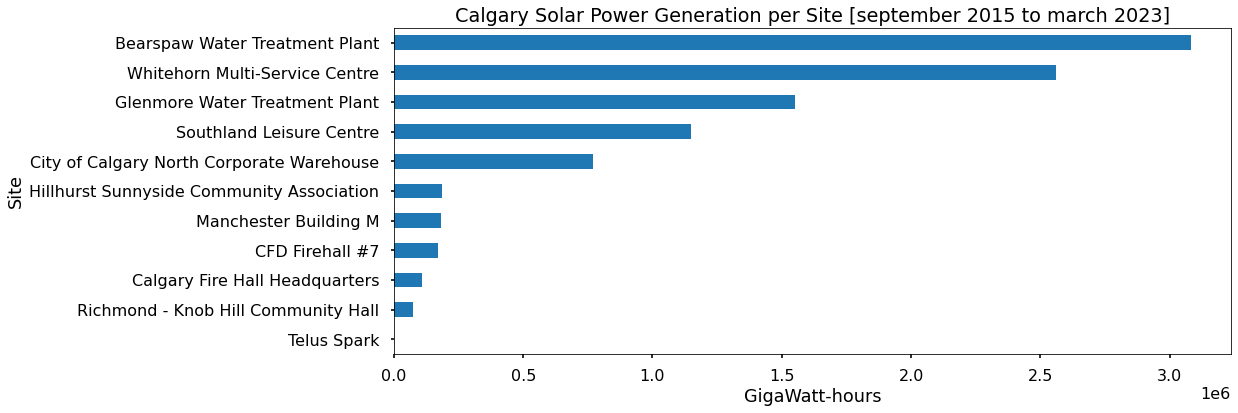

In [8]:
site_totals = site_totals.sort_values(by='kWh', ascending=True)

site_totals.plot(figsize=(15, 6), kind='barh', legend=False)
plt.title('Calgary Solar Power Generation per Site [september 2015 to march 2023]')
plt.xlabel('GigaWatt-hours')
plt.ylabel('Site')

plt.show()

#### Dataframe para análisis de series de tiempo

In [9]:
# create df for time series analysis
df['date'] = pd.to_datetime(df['date']) 

df_pw = df.drop(columns= ['name', 'id', 'address', 'public_url', 'installationDate', 'uid'])
df_pw = df_pw.set_index('date')

df_pw.head() 

,kWh
date,
2017-09-11 08:00:00,1.130
2017-09-11 09:00:00,2.340
2017-09-11 10:00:00,3.656
2017-09-11 11:00:00,4.577
2017-09-11 12:00:00,6.506


Cambiamos la frecuencia al acumulado de producción de energía solar por día.  

In [10]:
#change to daily frequency
count_date = df_pw.groupby(df_pw.index.date)['kWh'].sum()

pw_clean = pd.DataFrame(count_date)
pw_clean['date'] = pd.to_datetime(pw_clean.index) 
pw_clean = pw_clean.set_index('date')

pw_clean.head()

,kWh
date,
2015-09-01,286.013
2015-09-02,681.646
2015-09-03,647.906
2015-09-04,102.448
2015-09-05,93.432


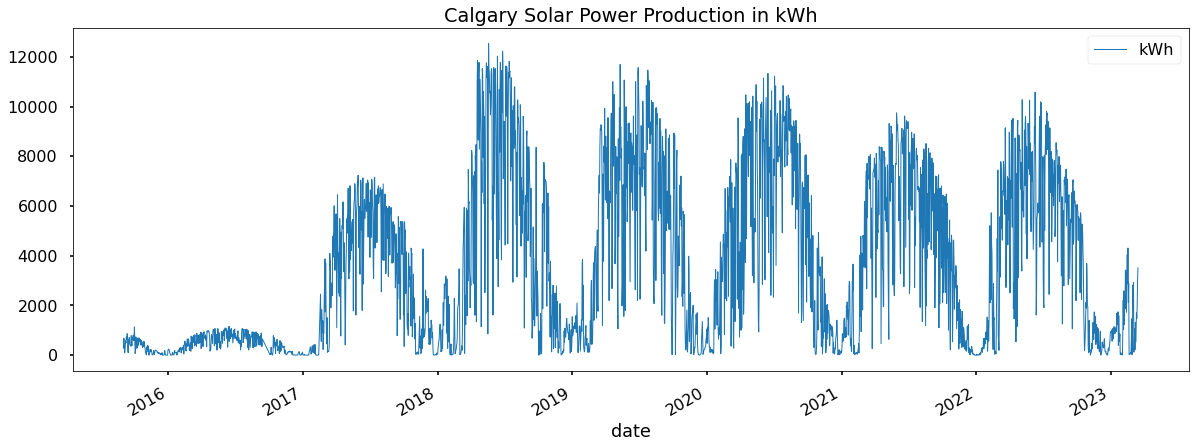

In [11]:
#plot the data
pw_clean.plot(style='-', figsize=(20, 7), lw=1,
              title='Calgary Solar Power Production in kWh')
plt.show()

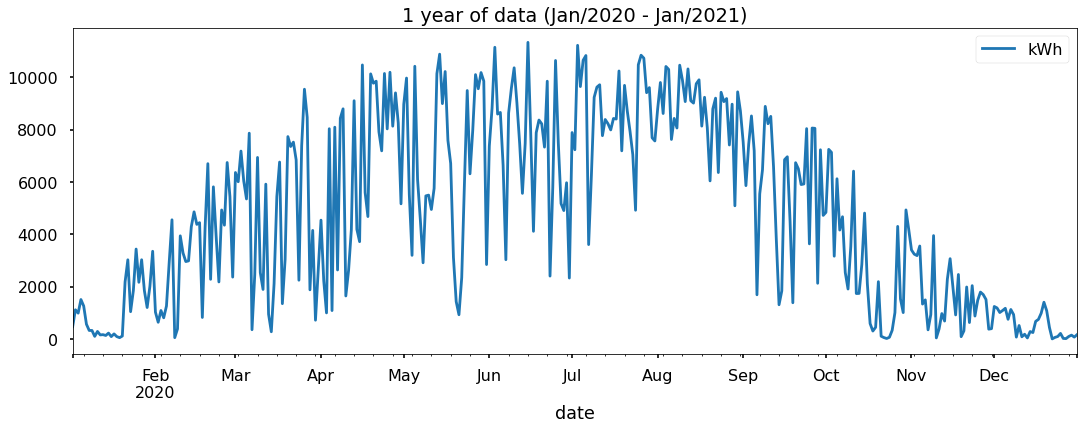

In [12]:
pw_clean.loc[(pw_clean.index > '2020-01-01') & (pw_clean.index < '2021-01-01')] \
    .plot(style='-', figsize=(18, 6), title='1 year of data (Jan/2020 - Jan/2021)')
plt.show()

#### Set de Entrenamiento / Prueba

**Por simplicidad, removemos los datos anteriores a 2018. Observamos que hastaa finales de 2017 se finalizó la instalación de todos los sitios.**  

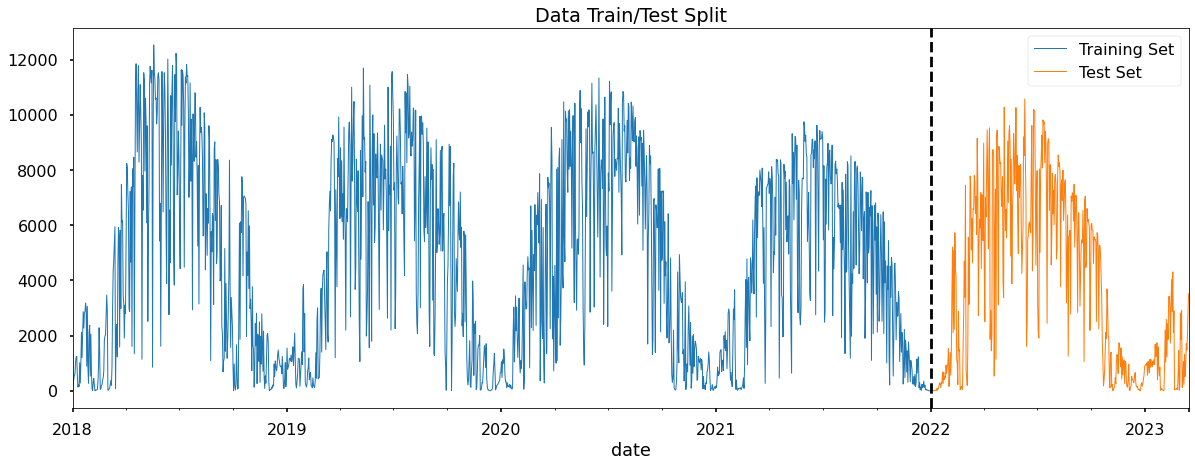

In [13]:
# remove data prior to 2017
pw_clean = pw_clean.loc[pw_clean.index >= '01-01-2018']

# test/train split 80% - 20%
train = pw_clean.loc[pw_clean.index < '01-01-2022']
test = pw_clean.loc[pw_clean.index >= '01-01-2022']

fig, ax = plt.subplots(figsize=(20, 7))
train.plot(ax=ax, style='-', lw=1, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, style='-', lw=1, label='Test Set')
ax.axvline('01-01-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## **Creación de Atributos (Feature Engineering)**

**Atributos basados en el índice de la serie de tiempo**

In [14]:
# create a function to create time series features
def create_atributes(df):
    df = df.copy()
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

pw_clean = create_atributes(pw_clean)

In [15]:
pw_clean.head()

,kWh,day,dayofweek,month,quarter,year,dayofyear
date,,,,,,,
2018-01-01,43.669,1,0,1,1,2018,1
2018-01-02,314.862,2,1,1,1,2018,2
2018-01-03,439.963,3,2,1,1,2018,3
2018-01-04,573.229,4,3,1,1,2018,4
2018-01-05,630.104,5,4,1,1,2018,5


#### Visualizacion de attributos contra target

**kWh por Mes**

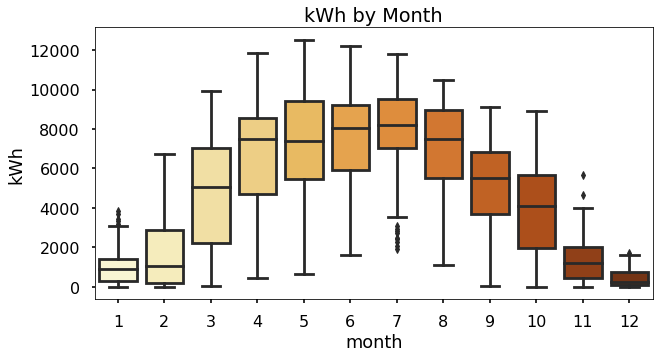

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=pw_clean, x='month', y='kWh', palette='YlOrBr')
ax.set_title('kWh by Month')
plt.show()

**kWh por cuarto**

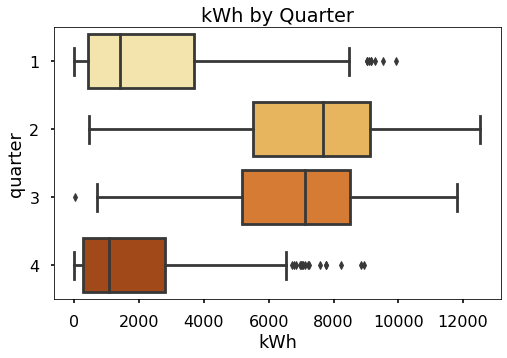

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=pw_clean, y='quarter', x='kWh', 
            orient='h', palette='YlOrBr')
ax.set_title('kWh by Quarter')
plt.show()

## **Modelado**

In [18]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error 

#### **1. Validación cruzada (Cross Validation)**

https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split 

In [19]:
# 4 fold cross validation
ts_cv = TimeSeriesSplit(n_splits=4)

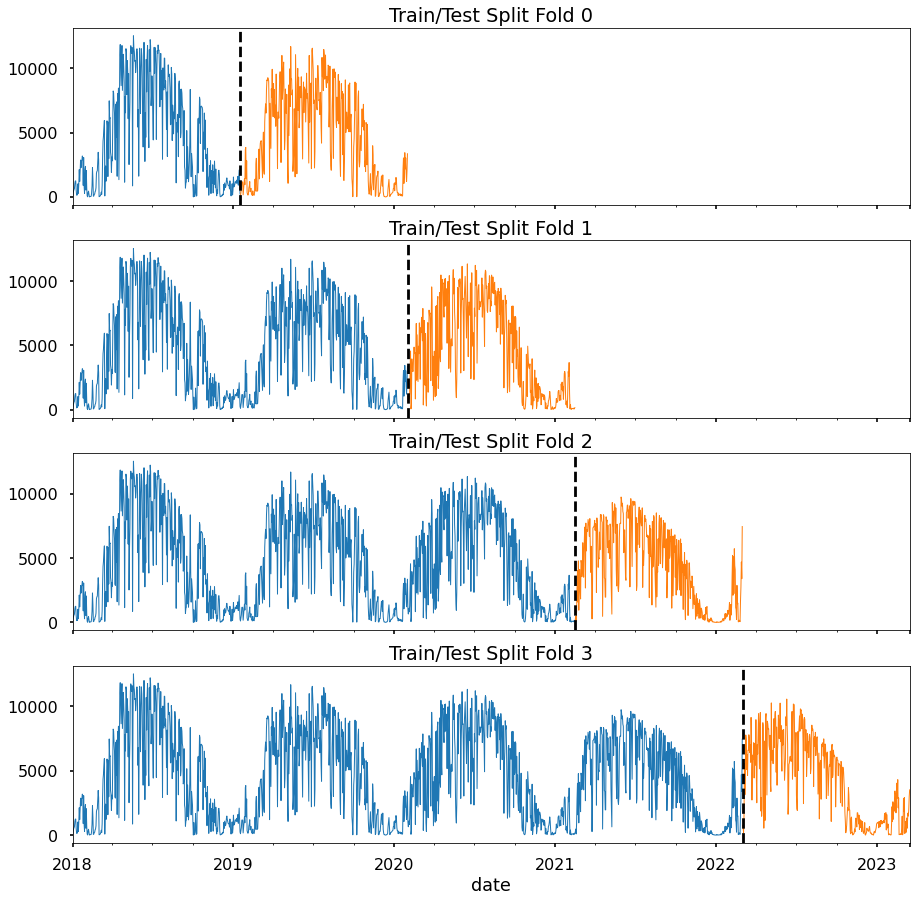

In [20]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in ts_cv.split(pw_clean):
    train = pw_clean.iloc[train_idx]
    test = pw_clean.iloc[val_idx]
    train['kWh'].plot(ax=axs[fold], lw=1,
                      label='Training Set',
                      title=f'Train/Test Split Fold {fold}')
    test['kWh'].plot(ax=axs[fold], lw=1,
                     label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

#### **2. Entrenando el modelo**

In [21]:
#cross validation split
ts_cv = TimeSeriesSplit(n_splits=4)

fold = 0
preds = []
scores = []

for train_idx, val_idx in ts_cv.split(pw_clean):
    train = pw_clean.iloc[train_idx]
    test = pw_clean.iloc[val_idx]

    #add features
    train = create_atributes(train)
    test = create_atributes(test)

    features = ['day','dayofweek','month','quarter','year','dayofyear']
    target = ['kWh']
    
    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]

    xgb_reg = xgb.XGBRegressor(booster='gbtree',
                               seed=42,        
                               n_estimators=1000,
                               early_stopping_rounds=50,
                               objective='reg:squarederror',
                               reg_lambda=0.001, 
                               max_depth=5,
                               eta=0.01)

    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:5925.63593	validation_1-rmse:5718.61436
[100]	validation_0-rmse:2680.65178	validation_1-rmse:3003.14544
[200]	validation_0-rmse:1733.72350	validation_1-rmse:2602.45499
[278]	validation_0-rmse:1481.71259	validation_1-rmse:2614.91330
[0]	validation_0-rmse:5823.53672	validation_1-rmse:5798.48212
[100]	validation_0-rmse:2755.29500	validation_1-rmse:3053.36244
[200]	validation_0-rmse:1936.68297	validation_1-rmse:2487.13767
[300]	validation_0-rmse:1695.04335	validation_1-rmse:2440.94589
[325]	validation_0-rmse:1658.62696	validation_1-rmse:2446.52811
[0]	validation_0-rmse:5814.84175	validation_1-rmse:5224.80100
[100]	validation_0-rmse:2795.00699	validation_1-rmse:2488.68440
[200]	validation_0-rmse:2011.82996	validation_1-rmse:2118.58626
[252]	validation_0-rmse:1876.78552	validation_1-rmse:2140.66667
[0]	validation_0-rmse:5674.55727	validation_1-rmse:5233.00698
[100]	validation_0-rmse:2776.23708	validation_1-rmse:2548.19884
[200]	validation_0-rmse:2027.39726	validation_1-

**Importancia de atributos**

In [22]:
feat_imp = pd.DataFrame(xgb_reg.feature_importances_,
                        index=xgb_reg.feature_names_in_,
                        columns=['Importance'])

feat_imp.sort_values('Importance', ascending=False)

,Importance
dayofyear,0.701667
month,0.123143
year,0.088794
dayofweek,0.046945
day,0.039450
quarter,0.000000


#### **3. Evaluación del modelo**

In [23]:
print('Avg. Score:', np.mean(scores))
print('Fold scores:', scores)

Avg. Score: 2275.3517403310516
Fold scores: [2598.514863235386, 2435.9595990180537, 2117.653168183066, 1949.2793308876999]


## **Predicciones** 

#### **1. Re-entrenamos el modelo con el dataset completo**

In [24]:
#full dataset
pw_clean = pw_clean.loc[pw_clean.index >= '01-01-2018'].copy()
pw_clean = create_atributes(pw_clean)

features = ['day','dayofweek','month','quarter','year','dayofyear']
target = ['kWh']

X_full = pw_clean[features]
y_full = pw_clean[target]

In [25]:
xgb_regf = xgb.XGBRegressor(booster='gbtree',
                               seed=42,        
                               n_estimators=1000,
                               early_stopping_rounds=50,
                               objective='reg:squarederror',
                               reg_lambda=0.001,
                               max_depth=5,
                               eta=0.01)

xgb_regf.fit(X_full, y_full,
        eval_set=[(X_full, y_full)],
        verbose=100)

[0]	validation_0-rmse:5588.87115
[100]	validation_0-rmse:2726.92456
[200]	validation_0-rmse:2007.11956
[300]	validation_0-rmse:1825.18581
[400]	validation_0-rmse:1733.12736
[500]	validation_0-rmse:1664.93076
[600]	validation_0-rmse:1605.89970
[700]	validation_0-rmse:1559.79422
[800]	validation_0-rmse:1521.43837
[900]	validation_0-rmse:1479.22735
[999]	validation_0-rmse:1437.66343


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

#### **2. Crear dataframe futuro**

In [26]:
pw_clean.index.max()

Timestamp('2023-03-16 00:00:00')

**6 meses en el futuro**

In [27]:
# march to september 2023
pred_dates = pd.date_range('2023-03-16','2023-09-17', freq='D')
preds_df = pd.DataFrame(index=pred_dates)

#Create column with booleans where future dates = True
preds_df['Future'] = True
pw_clean['Future'] = False

#Concatenate both df's
pred_pw = pd.concat([pw_clean.loc[pw_clean.index >= '01-01-2018'], preds_df]) 

In [28]:
#add features
pred_pw = pred_pw.copy()
pred_pw = create_atributes(pred_pw)

pred_pw.tail()

,kWh,day,dayofweek,month,quarter,year,dayofyear,Future
2023-09-13,NaN,13,2,9,3,2023,256,True
2023-09-14,NaN,14,3,9,3,2023,257,True
2023-09-15,NaN,15,4,9,3,2023,258,True
2023-09-16,NaN,16,5,9,3,2023,259,True
2023-09-17,NaN,17,6,9,3,2023,260,True


In [29]:
#create df with future dates only
future_pred_pw = pred_pw.query('Future').copy()
future_pred_pw.head()

,kWh,day,dayofweek,month,quarter,year,dayofyear,Future
2023-03-16,NaN,16,3,3,1,2023,75,True
2023-03-17,NaN,17,4,3,1,2023,76,True
2023-03-18,NaN,18,5,3,1,2023,77,True
2023-03-19,NaN,19,6,3,1,2023,78,True
2023-03-20,NaN,20,0,3,1,2023,79,True


#### **3. Prediciendo el futuro**

In [30]:
#create column with predictions
future_pred_pw['prediction'] = xgb_regf.predict(future_pred_pw[features])

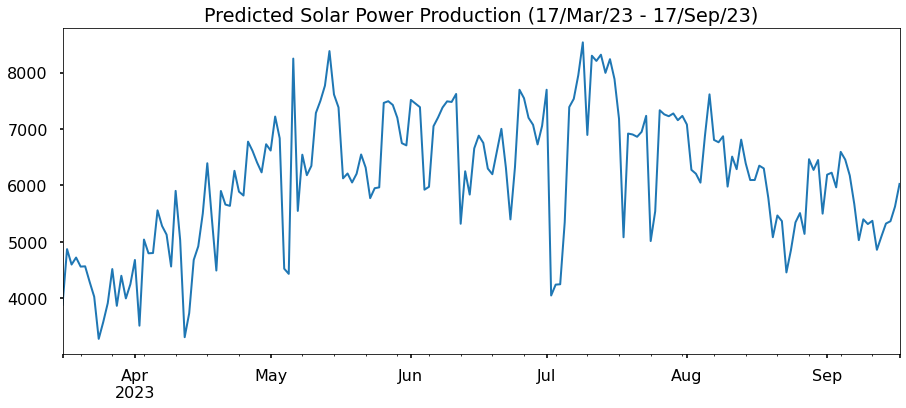

In [31]:
future_pred_pw['prediction'].plot(figsize=(15, 6), lw=2,
                                  title='Predicted Solar Power Production (17/Mar/23 - 17/Sep/23)')
plt.show()

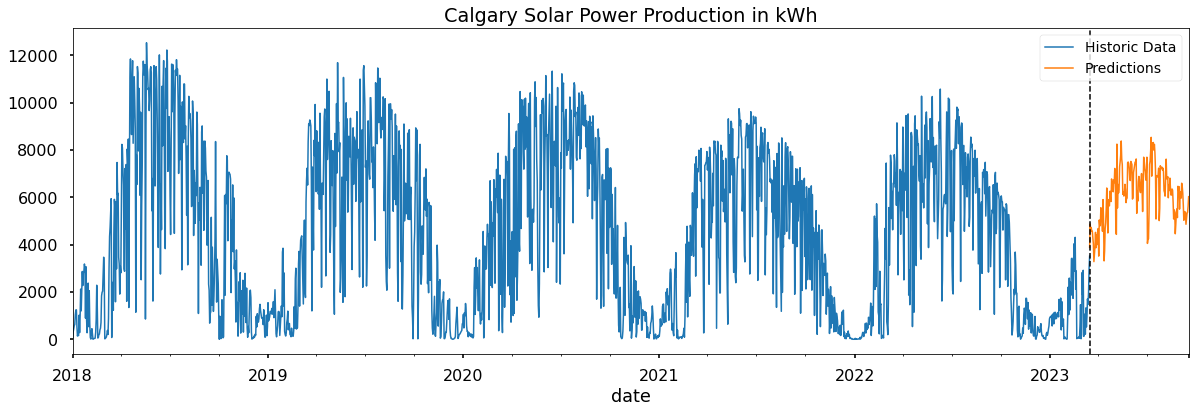

In [39]:
ax = pw_clean['kWh'].loc[pw_clean.index >= '01-01-2018']\
    .plot(figsize=(20, 6), lw=1.5, title='Calgary Solar Power Production in kWh')
future_pred_pw['prediction'].plot(style='-', lw=1.5)
ax.axvline('2023-03-16', color='black', ls='--', lw=1.5)
plt.legend(['Historic Data','Predictions'], fontsize=14)
plt.show()